# Required Assignment 5.1: Will the Customer Accept the Coupon?

**Context**

Imagine driving through town and a coupon is delivered to your cell phone for a restaurant near where you are driving. Would you accept that coupon and take a short detour to the restaurant? Would you accept the coupon but use it on a subsequent trip? Would you ignore the coupon entirely? What if the coupon was for a bar instead of a restaurant? What about a coffee house? Would you accept a bar coupon with a minor passenger in the car? What about if it was just you and your partner in the car? Would weather impact the rate of acceptance? What about the time of day?

Obviously, proximity to the business is a factor on whether the coupon is delivered to the driver or not, but what are the factors that determine whether a driver accepts the coupon once it is delivered to them? How would you determine whether a driver is likely to accept a coupon?

**Overview**

The goal of this project is to use what you know about visualizations and probability distributions to distinguish between customers who accepted a driving coupon versus those that did not.

**Data**

This data comes to us from the UCI Machine Learning repository and was collected via a survey on Amazon Mechanical Turk. The survey describes different driving scenarios including the destination, current time, weather, passenger, etc., and then ask the person whether he will accept the coupon if he is the driver. Answers that the user will drive there ‘right away’ or ‘later before the coupon expires’ are labeled as ‘Y = 1’ and answers ‘no, I do not want the coupon’ are labeled as ‘Y = 0’.  There are five different types of coupons -- less expensive restaurants (under \$20), coffee houses, carry out & take away, bar, and more expensive restaurants (\$20 - $50).


## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import math

## Import Data

In [2]:
data = pd.read_csv('data/coupons.csv')


## Inspect Data 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passanger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   time                  12684 non-null  object
 5   coupon                12684 non-null  object
 6   expiration            12684 non-null  object
 7   gender                12684 non-null  object
 8   age                   12684 non-null  object
 9   maritalStatus         12684 non-null  object
 10  has_children          12684 non-null  int64 
 11  education             12684 non-null  object
 12  occupation            12684 non-null  object
 13  income                12684 non-null  object
 14  car                   108 non-null    object
 15  Bar                   12577 non-null

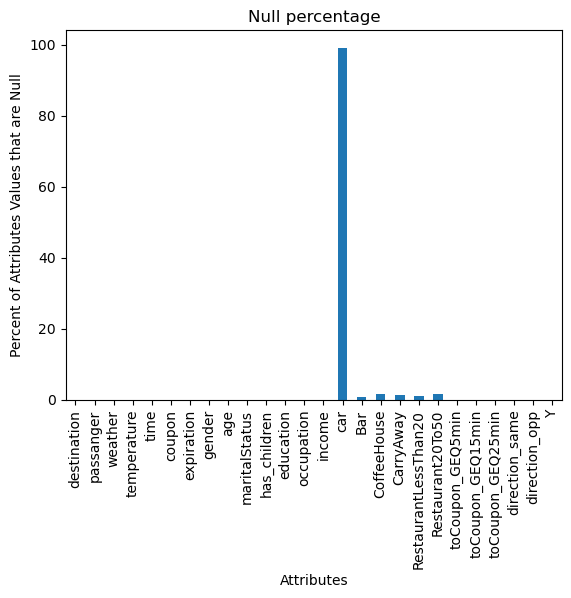

In [3]:
#Iterate through the columns and discover potential values for each

#Get column names
data_column_names = list(data.columns)

#Get the types of the columns
print(data.info())

#Get unique values present in the data for each column 
for data_column_name in data_column_names:
    print(data_column_name, data[data_column_name].unique())

#Get percent of nulls in the data for each attribute
dataNumNulls= {}
dataIsNulls = data.isnull()

for columnName in data_column_names:
    value = True
    print(columnName)
    # Using f-string to insert the column name variable
    query_string = f"`{columnName}` == {value}"
    dataNumNulls[columnName] = dataIsNulls.query(query_string).shape[0]

dataNumNullSeries = pd.Series(dataNumNulls)

dataNumNullsPercent = (dataNumNullSeries/data.shape[0]) * 100

dataNumNullsPercent.plot.bar()

plt.title('Null percentage')
plt.xlabel('Attributes')
plt.ylabel('Percent of Attributes Values that are Null')

#Get total number of columns
plt.show()


<ins>Observations: </ins>
- Values for coupon and the respective columns do not match. Replace the coupon values to match the column names in the data set
- Car column is mostly null. We should remove it completely.
- The number of nans in the Bar, CoffeeHouse, CarryAway, RestaurantLessThan20, Restaurant20To50 is low. Lets remove the rows with nans in those columns

<ins>Assumptions(Should seek clarification on these points if possible):</ins> 
- For the purpose of this exercise Restautrant<20 coupon is for the same place the distance of RestaurantLessThan20 etc. They are talking about the same resturant.

<ins>Filter Outliers:</ins>
- Direction_same is always the opposite of direction_opp
- Value of Y for Coupon VarX is 0 when frequency of VarX is "never" where VarX could be [Bar, CoffeeHouse, CarryAway, RestaurantLessThen20, Restaurant20to50]
- If the weather is 'Snowy' temperature should not be 80
- toCoupon_GEQ25min is 1 then toCoup_GEQ15min is 1. We already see toCoupon_GEQ5min is always 1.

### Clean Data

In [4]:
#Replace coupon values to match there corresponding row
dataV2=data.copy()
dataV2['coupon']=dataV2['coupon'].str.replace('Restaurant(<20)','RestaurantLessThan20', regex=False)
dataV2['coupon']=dataV2['coupon'].str.replace('Coffee House', 'CoffeeHouse', regex=False)
dataV2['coupon']=dataV2['coupon'].str.replace('Carry out & Take away', 'CarryAway', regex=False)
dataV2['coupon']=dataV2['coupon'].str.replace('Restaurant(20-50)', 'Restaurant20To50', regex=False)

#Confirm change in values for coupon column
print('coupon', dataV2['coupon'].unique())
print(' ')

#remove car column
dataV2.drop('car', axis=1, inplace=True)


#Confirm column removal
print(dataV2.columns)

#remove remaining na containing rows
dataV2.dropna(subset = ['RestaurantLessThan20', 'CoffeeHouse', 'CarryAway', 'Restaurant20To50', 'Bar'], inplace=True)


coupon ['RestaurantLessThan20' 'CoffeeHouse' 'CarryAway' 'Bar' 'Restaurant20To50']
 
Index(['destination', 'passanger', 'weather', 'temperature', 'time', 'coupon',
       'expiration', 'gender', 'age', 'maritalStatus', 'has_children',
       'education', 'occupation', 'income', 'Bar', 'CoffeeHouse', 'CarryAway',
       'RestaurantLessThan20', 'Restaurant20To50', 'toCoupon_GEQ5min',
       'toCoupon_GEQ15min', 'toCoupon_GEQ25min', 'direction_same',
       'direction_opp', 'Y'],
      dtype='object')


### Test Invariants

In [5]:
dataV2.query("direction_same == direction_opp").shape[0] #value should be 0

0

In [6]:
for coupon_value in list(dataV2['coupon'].unique()):
    print(coupon_value, dataV2.query("coupon == @coupon_value and @coupon_value == 'never' and Y == 1").shape[0]) #values should be 0

RestaurantLessThan20 0
CoffeeHouse 0
Bar 0
CarryAway 0
Restaurant20To50 0


In [7]:
dataV2.query("weather == 'Snow' and temperature != 80").shape[0] #value should be 0

0

In [8]:
dataV2.query("toCoupon_GEQ25min == 1 and toCoupon_GEQ15min == 0").shape[0] #value should be 0

0

## Begin Analysis

In [9]:
### From prompt

What proportion of the total observations chose to accept the coupon?

In [10]:
print(str(dataV2.query( "Y == 1").shape[0]/dataV2.shape[0]*100) + " percent ")

56.93352098683666 percent 


Use a bar plot to visualize the coupon column.

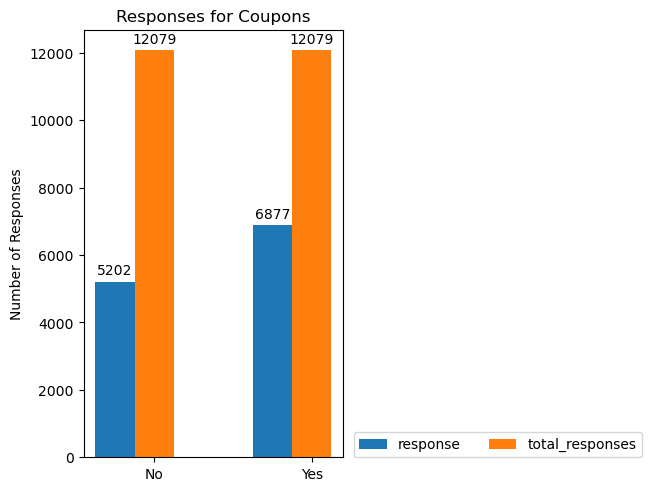

In [11]:
index_labels = ["No", "Yes"]

list_data = {
    'response': (dataV2.query("Y == 0").shape[0], dataV2.query("Y == 1").shape[0]),
    'total_responses': (dataV2.shape[0], dataV2.shape[0])
}

x = np.arange(len(index_labels))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in list_data.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Responses')
ax.set_title('Responses for Coupons')
ax.set_xticks(x + width, index_labels)
ax.legend(loc=(1.04, 0), ncols=2)


plt.show()


Use a histogram to visualize the temperature column.

<Axes: xlabel='temperature', ylabel='Count'>

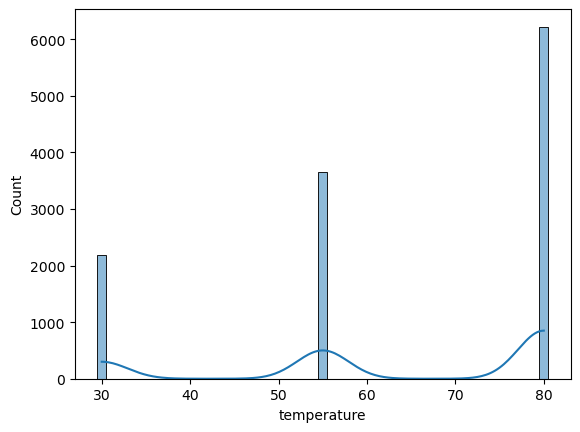

In [12]:


temperatureDataSlice = dataV2['temperature']

#Seaborn has better histograms then matplotlib currently in my opinion
#Parameters for Seaborn histogram plots https://seaborn.pydata.org/generated/seaborn.histplot.html

sns.histplot(data=dataV2, x='temperature', discrete = True, kde = True)



**Investigating the Bar Coupons**

Now, we will lead you through an exploration of just the bar related coupons.  

1. Create a new `DataFrame` that contains just the bar coupons.

In [13]:
barData = dataV2.query("coupon == 'Bar'")
type(barData)

pandas.core.frame.DataFrame

2. What proportion of bar coupons were accepted?

In [14]:
print(str(barData.query( "Y == 1").shape[0]/barData.shape[0]*100) + " percent ")

41.19184526921067 percent 


3. Compare the acceptance rate between those who went to a bar 3 or fewer times a month to those who went more.

In [15]:
ThreeOrLessValues = ['never', 'less1', '1~3']

numSentThreeOrLessBar = barData.query( "Bar.isin(@ThreeOrLessValues)").shape[0]
numAcceptanceRateThreeOrLessBar = barData.query( "Y == 1 and Bar.isin(@ThreeOrLessValues)").shape[0]
numAcceptanceRateMoreThenThreeBar = barData.query( "Y == 1 and ~Bar.isin(@ThreeOrLessValues)").shape[0]

acceptanceRateThreeOrLessBar = (str(numAcceptanceRateThreeOrLessBar/numSentThreeOrLessBar*100) + " percent ")
print('The acceptance rate when the target went three or less times is ' + acceptanceRateThreeOrLessBar)



acceptanceRateMoreThenThreeBar = (str(numAcceptanceRateMoreThenThreeBar/numSentThreeOrLessBar*100) + " percent ")
print('The acceptance rate when the target went more then three times is ' + acceptanceRateMoreThenThreeBar)


The acceptance rate when the target went three or less times is 37.26744186046512 percent 
The acceptance rate when the target went more then three times is 8.546511627906977 percent 


4. Compare the acceptance rate between drivers who go to a bar more than once a month and are over the age of 25 to the all others.  Is there a difference?


In [16]:
OneOrMoreTimesBarValues = ['1~3', 'gt8','4~8']
GreaterThen25AgeValues = ['46', '26', '31', '41', '50plus', '36']

numSentOneOrMoreBarGreaterThen25Age = barData.query( "Bar.isin(@OneOrMoreTimesBarValues) and age.isin(@GreaterThen25AgeValues)").shape[0]
numRateOneOrMoreBarGreaterThen25Age = barData.query( "Y == 1 and Bar.isin(@OneOrMoreTimesBarValues) and age.isin(@GreaterThen25AgeValues)").shape[0]

acceptanceRateOneOrMoreBarGreaterThen25Age = (str(numRateOneOrMoreBarGreaterThen25Age/numSentOneOrMoreBarGreaterThen25Age*100) + " percent ")

print('The acceptance rate when the target goes to the bar more then one time a month and is older then 25 ' + acceptanceRateOneOrMoreBarGreaterThen25Age)

numSentNotOneOrMoreBarGreaterThen25Age = barData.query( "~Bar.isin(@OneOrMoreTimesBarValues) and age.isin(@GreaterThen25AgeValues)").shape[0]
numRateNotOneOrMoreBarGreaterThen25Age = barData.query( "Y == 1 and ~Bar.isin(@OneOrMoreTimesBarValues) and age.isin(@GreaterThen25AgeValues)").shape[0]

acceptanceRateLessThenOneBarLessThen25Age = (str(numRateNotOneOrMoreBarGreaterThen25Age/numSentNotOneOrMoreBarGreaterThen25Age*100) + " percent ")

print('The acceptance rate when the target does not go to the bar more then one time a month and is older then 25 ' + acceptanceRateLessThenOneBarLessThen25Age)



The acceptance rate when the target goes to the bar more then one time a month and is older then 25 68.98263027295285 percent 
The acceptance rate when the target does not go to the bar more then one time a month and is older then 25 26.744186046511626 percent 


5. Use the same process to compare the acceptance rate between drivers who go to bars more than once a month and had passengers that were not a kid and had occupations other than farming, fishing, or forestry.

In [17]:
OneOrMoreTimesBarValues = ['1~3', 'gt8','4~8']
PassengersThatWereNotAKidValues = ['Alone','Friend(s)','Partner']
FarmingFishingForestryOccupationValue = 'Farming Fishing & Forestry'

numSentBarsMoreThenOncePassengersThatWereNotAKidNotInFarmingFishinForestyOccupationValue = barData.query( "Bar.isin(@OneOrMoreTimesBarValues) and passanger.isin(@PassengersThatWereNotAKidValues) and occupation != @FarmingFishingForestryOccupationValue").shape[0]
numRateBarsMoreThenOncePassengersThatWereNotAKidNotInFarmingFishinForestyOccupationValue = barData.query( "Y == 1 and Bar.isin(@OneOrMoreTimesBarValues) and passanger.isin(@PassengersThatWereNotAKidValues) and occupation != @FarmingFishingForestryOccupationValue").shape[0]

acceptanceRate = (str(numRateBarsMoreThenOncePassengersThatWereNotAKidNotInFarmingFishinForestyOccupationValue/numSentBarsMoreThenOncePassengersThatWereNotAKidNotInFarmingFishinForestyOccupationValue*100) + " percent ")

print('Go to bars more then once and no kid passenger and not in rural occupation acceptance rate is  ' + acceptanceRate)


Go to bars more then once and no kid passenger and not in rural occupation acceptance rate is  70.94339622641509 percent 


6. Compare the acceptance rates between those drivers who:

- go to bars more than once a month, had passengers that were not a kid, and were not widowed *OR*
- go to bars more than once a month and are under the age of 30 *OR*
- go to cheap restaurants more than 4 times a month and income is less than 50K.


In [18]:
OneOrMoreTimesBarValues = ['1~3', 'gt8','4~8'] #Bar
PassengersThatWereNotAKidValues = ['Alone','Friend(s)','Partner'] #passenger
MaritalStatusWidowedValue = 'Widowed' #maritalStatus  
UnderThe30AgeValues = ['21', '26', 'below21'] #age
CheapResturantsMoreThen4TimesValues = ['4~8', 'gt8'] #RestaurantLessThan20  
IncomeLessThen50k = ['$37500 - $49999', '$12500 - $24999', '$25000 - $37499', 'Less than $12500'] #income                

numSentBarsMoreThenOncePassengersThatWereNotAKidNotWidow = barData.query( "Bar.isin(@OneOrMoreTimesBarValues) and passanger.isin(@PassengersThatWereNotAKidValues) and maritalStatus != @MaritalStatusWidowedValue").shape[0]
numRateBarsMoreThenOncePassengersThatWereNotAKidNotWidow = barData.query( "Y == 1 and Bar.isin(@OneOrMoreTimesBarValues) and passanger.isin(@PassengersThatWereNotAKidValues) and maritalStatus != @MaritalStatusWidowedValue").shape[0]

print("go to bars more than once a month, had passengers that were not a kid, and were not widowed acceptance rate " + str(numRateBarsMoreThenOncePassengersThatWereNotAKidNotWidow/numSentBarsMoreThenOncePassengersThatWereNotAKidNotWidow*100))

numSentBarsMoreThenOncePassengersAgeUnder30 = barData.query( "Bar.isin(@OneOrMoreTimesBarValues) and age.isin(@UnderThe30AgeValues)").shape[0]
numRateBarsMoreThenOncePassengersAgeUnder30 = barData.query( "Y == 1 and Bar.isin(@OneOrMoreTimesBarValues) and age.isin(@UnderThe30AgeValues)").shape[0]

print("go to bars more than once a month and are under the age of 30 acceptance rate " + str(numRateBarsMoreThenOncePassengersAgeUnder30/numSentBarsMoreThenOncePassengersAgeUnder30*100))

numSentCheapRestaurantsMoreThen4TimesIncomeLessThen50k = barData.query( "RestaurantLessThan20.isin(@CheapResturantsMoreThen4TimesValues) and income.isin(@IncomeLessThen50k)").shape[0]
numRateCheapRestaurantsMoreThen4TimesIncomeLessThen50k = barData.query( "Y == 1 and RestaurantLessThan20.isin(@CheapResturantsMoreThen4TimesValues) and income.isin(@IncomeLessThen50k)").shape[0]

print("go to cheap restaurants more than 4 times a month and income is less than 50K acceptance rate " + str(numRateCheapRestaurantsMoreThen4TimesIncomeLessThen50k/numSentCheapRestaurantsMoreThen4TimesIncomeLessThen50k*100))



go to bars more than once a month, had passengers that were not a kid, and were not widowed acceptance rate 70.94339622641509
go to bars more than once a month and are under the age of 30 acceptance rate 71.95121951219512
go to cheap restaurants more than 4 times a month and income is less than 50K acceptance rate 45.645645645645644


7.  Based on these observations, what do you hypothesize about drivers who accepted the bar coupons?

### Independent Investigation

Using the bar coupon example as motivation, you are to explore one of the other coupon groups and try to determine the characteristics of passengers who accept the coupons. 

For my independant investigation I will explore what different attributes affect cheap restaurant acceptance.

What is the overall acceptance rate of the coupon for cheap restaurans?

In [19]:
cheapRestaurantData = dataV2.query("coupon == 'RestaurantLessThan20'")
print(str(cheapRestaurantData.query( "Y == 1").shape[0]/cheapRestaurantData.shape[0]*100) + " percent ")

70.9008669430833 percent 


What is the acceptance rate based on proximity to the venue?

In [20]:

numSent25MinOutGreaterThen15MinOut = cheapRestaurantData.query("toCoupon_GEQ25min == 0 and toCoupon_GEQ15min == 1 ").shape[0]
numRate25MinOutGreaterThen15MinOut = cheapRestaurantData.query( "Y == 1 and toCoupon_GEQ25min == 0 and toCoupon_GEQ15min == 1").shape[0]

print("Acceptance rate less then 25 min out " + str(numRate25MinOutGreaterThen15MinOut/numSent25MinOutGreaterThen15MinOut * 100))


numSent15MinOut = cheapRestaurantData.query("toCoupon_GEQ15min == 0 ").shape[0]
numRate15MinOut = cheapRestaurantData.query( "Y == 1 and toCoupon_GEQ15min == 0 ").shape[0]

print("Acceptance rate less then 15 min out " + str(numRateBarsMoreThenOncePassengersThatWereNotAKidNotWidow/numSentBarsMoreThenOncePassengersThatWereNotAKidNotWidow * 100))


Acceptance rate less then 25 min out 75.47806524184477
Acceptance rate less then 15 min out 70.94339622641509


In [21]:

numSentDirectionSame = cheapRestaurantData.query("direction_same  == 1").shape[0]
numRateDirectionSame = cheapRestaurantData.query( "Y == 1 and direction_same  == 1").shape[0]

print("Acceptance rate direction the same " + str(numRateDirectionSame/numSentDirectionSame * 100))



numSentDirectionOpposite = cheapRestaurantData.query("direction_same  == 0").shape[0]
numRateDirectionOpposite = cheapRestaurantData.query( "Y == 1 and direction_same  == 0").shape[0]

print("Acceptance rate direction the opposite " + str(numRateDirectionOpposite/numSentDirectionOpposite * 100))


Acceptance rate direction the same 63.48547717842323
Acceptance rate direction the opposite 72.54721326577615


Which Occupation had the highest acceptance rate for cheap restaurants?

In [22]:
for data_column_value in data['occupation'].unique():
    numSent = cheapRestaurantData.query("occupation == @data_column_value").shape[0]
    numAccepted = cheapRestaurantData.query( "Y == 1 and occupation == @data_column_value").shape[0]
    print("Acceptance rate "+ data_column_value + " " + str(numAccepted/numSent * 100))

Acceptance rate Unemployed 67.00251889168766
Acceptance rate Architecture & Engineering 79.48717948717949
Acceptance rate Student 71.47239263803681
Acceptance rate Education&Training&Library 67.33668341708542
Acceptance rate Healthcare Support 73.58490566037736
Acceptance rate Healthcare Practitioners & Technical 77.77777777777779
Acceptance rate Sales & Related 79.82832618025752
Acceptance rate Management 73.14285714285714
Acceptance rate Arts Design Entertainment Sports & Media 67.74193548387096
Acceptance rate Computer & Mathematical 70.79037800687286
Acceptance rate Life Physical Social Science 83.33333333333334
Acceptance rate Personal Care & Service 55.88235294117647
Acceptance rate Community & Social Services 67.3913043478261
Acceptance rate Office & Administrative Support 77.27272727272727
Acceptance rate Construction & Extraction 88.57142857142857
Acceptance rate Legal 59.183673469387756
Acceptance rate Retired 58.0952380952381
Acceptance rate Installation Maintenance & Repair

In [23]:
for data_column_value in data['income'].unique():
    numSent = cheapRestaurantData.query("income == @data_column_value").shape[0]
    numAccepted = cheapRestaurantData.query( "Y == 1 and income == @data_column_value").shape[0]
    print("Acceptance rate "+ data_column_value + " " + str(numAccepted/numSent * 100))

Acceptance rate $37500 - $49999 68.29268292682927
Acceptance rate $62500 - $74999 69.5187165775401
Acceptance rate $12500 - $24999 67.90450928381962
Acceptance rate $75000 - $87499 68.85245901639344
Acceptance rate $50000 - $62499 77.34138972809667
Acceptance rate $25000 - $37499 76.70588235294117
Acceptance rate $100000 or More 71.81571815718158
Acceptance rate $87500 - $99999 57.608695652173914
Acceptance rate Less than $12500 71.9298245614035


Which education level had the highest aceptance rate?

In [24]:
for data_column_value in data['education'].unique():
    numSent = cheapRestaurantData.query("education == @data_column_value").shape[0]
    numAccepted = cheapRestaurantData.query( "Y == 1 and education == @data_column_value").shape[0]
    print("Acceptance rate "+ data_column_value + " " + str(numAccepted/numSent * 100))

Acceptance rate Some college - no degree 73.93162393162393
Acceptance rate Bachelors degree 73.12925170068027
Acceptance rate Associates degree 65.9090909090909
Acceptance rate High School Graduate 71.50537634408603
Acceptance rate Graduate degree (Masters or Doctorate) 61.55717761557178
Acceptance rate Some High School 72.22222222222221


Which age level had the highest aceptance rate?

In [25]:
for data_column_value in data['age'].unique():
    numSent = cheapRestaurantData.query("age == @data_column_value").shape[0]
    numAccepted = cheapRestaurantData.query( "Y == 1 and age == @data_column_value").shape[0]
    print("Acceptance rate "+ data_column_value + " " + str(numAccepted/numSent * 100))

Acceptance rate 21 73.80952380952381
Acceptance rate 46 75.0
Acceptance rate 26 74.18738049713193
Acceptance rate 31 70.81339712918661
Acceptance rate 41 71.60493827160494
Acceptance rate 50plus 63.94736842105263
Acceptance rate 36 64.76868327402136
Acceptance rate below21 73.72881355932203


Based on these observations, what do you hypothesize about drivers who accepted the cheap restaurant coupon?

Overall acceptance rate of bar coupons is around 70 percent. Acceptance rate for when target is 25min out vs 15min or less is significantly higher. The occupation Construction & Extraction had a significantly higher acceptance rate (80 percent). Age, Education and income did not significantly affect acceptance rate. 